# Compass Calibration

**I2c Chip:** HMC5883L

This notebook helps understand the range of values collected from the HMC5883L accelerometer and is used to assist in discovering ways to improve and calibrate the readings.

In [1561]:
import numpy as np
import matplotlib.pyplot as plt
import json
import exporter
import math

In [1614]:
def load_data(path):
    with open(path) as f:
        data = json.load(f)
    arr = np.asarray(data, dtype=np.float32)
    x = arr[:,0] + 25
    y = arr[:,1] + 252
    z = arr[:,2] + 16
    t = arr[:,3]
    
    return (x,y,z,t)

# Raw coordinates

This section is dedicated to extrapolating information from the raw coordinates. The goal is to ensure Y (or rotation, whichever axis that is) does not change at all when loading the `data_xyzm_raw_hzonly.json` file. This file contains data where the sensor was rotated along the x axis (like a compass) with zero rotation. Use the findings here to generate a calibration strategy and then in the next section, apply that strategy to explore how to keep the rotation axis still no matter the heading.

In [1642]:
def heading(x,y,z):
    deg = np.degrees(math.atan2(z,x))
    if deg < 0:
        deg = 360 - abs(deg)
    return deg % 360


def closest_factor(y_factor, heading):
    closest_key = 4096
    closest_val = 0.0
    for k,v in y_factor.items():
        difference = abs(heading - k)
        if difference < closest_key:
            closest_key = difference
            closest_val = v
    return closest_val


def apply_calibration(y_factor, x, y, z):
    ax = []
    ay = []
    az = []
    
    for idx in range(0, len(x)):
        px = x[idx]
        py = y[idx]
        pz = z[idx]
        h = int(heading(px, py, pz))
        
        mult_factor = closest_factor(y_factor, h)
        py = py * mult_factor

        if h >= 180:
            py *= -1
            
            
        if py > 2:
            py /= 10
        
    
        ax.append(px)
        ay.append(py)
        az.append(pz)
        
    return (np.asarray(ax), np.asarray(ay), np.asarray(az))


def zed(val):
    if val == 0:
        return 1.0
    else:
        return val

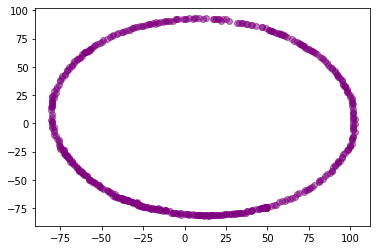

In [1643]:
x,y,z,t = load_data('data_xyzm_raw_hzonly.json')
# x,y,z,t = load_data('data_xyzm_raw_hzonly-smallquad.json')


# There is a positive correlation between heading and x/z
plt.scatter(x, z, alpha=0.5, color='purple')
plt.show()

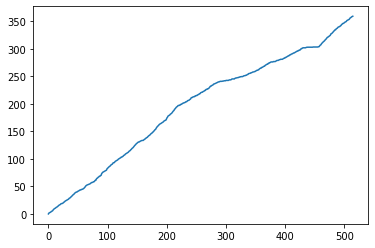

In [1644]:
# Determine the heading for each point
headings = []
for idx in range(0, len(x)):
    px = x[idx]
    py = y[idx]
    pz = z[idx]
    h = heading(px,py,pz)
    headings.append(h)
    
headings = np.sort(headings)

plt.plot(headings)
plt.show()

    

# Rotation
This section is dedicated to investigating the relationship between Y (rotation-axis) and other dimensions

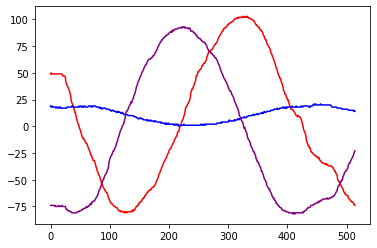

In [1645]:
# There is variance along the rotation axis relating directly to heading

plt.plot(x, color='red')
plt.plot(y, color='blue')
plt.plot(z, color='purple')
plt.show()


# Calibration

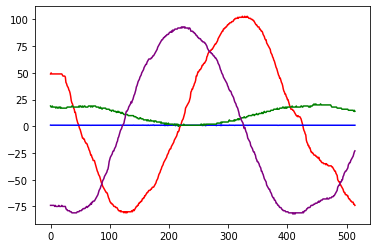

In [1646]:
y_factor = {}
y_factor_count = {}
y_adj = []
for idx in range(0, len(y)):
    px = x[idx]
    py = y[idx]
    pz = z[idx]
    h = round(heading(px,py,pz))
    
    if round(py) == 0:
        continue
    
    factor = (1 / py)
    
    if h in y_factor:
        y_factor[h] += factor
        y_factor_count[h] += 1.0
    else:
        y_factor[h] = factor
        y_factor_count[h] = 1.0

for k in y_factor.keys():
    y_factor[k] /= y_factor_count[k]
    
#     y_factor[k] = 1.0

for idx in range(0, len(y)):
    px = x[idx]
    py = y[idx]
    pz = z[idx]
    h = int(heading(px,py,pz))
    y_adj.append(py * closest_factor(y_factor, h))

plt.plot(x, color='red')
plt.plot(y_adj, color='blue')
plt.plot(y, color='green')
plt.plot(z, color='purple')


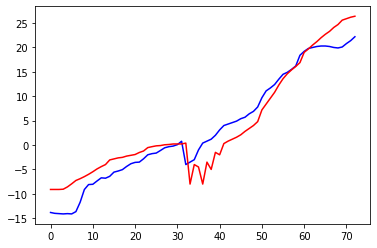

[0]  <77.0, 235.0, -185.0>   Heading: 292    Rotation: -13.8235
[1]  <78.0, 238.0, -185.0>   Heading: 292    Rotation: -14.0
[2]  <77.0, 239.0, -185.0>   Heading: 292    Rotation: -14.0588
[3]  <78.0, 240.0, -185.0>   Heading: 292    Rotation: -14.1176
[4]  <78.0, 239.0, -185.0>   Heading: 292    Rotation: -14.0588
[5]  <78.0, 240.0, -185.0>   Heading: 292    Rotation: -14.1176
[6]  <78.0, 232.0, -186.0>   Heading: 292    Rotation: -13.6471
[7]  <74.0, 207.0, -186.0>   Heading: 291    Rotation: -11.7255
[8]  <69.0, 161.0, -181.0>   Heading: 290    Rotation: -9.1198
[9]  <71.0, 143.0, -176.0>   Heading: 291    Rotation: -8.1002
[10]  <69.0, 142.0, -175.0>   Heading: 291    Rotation: -8.0436
[11]  <68.0, 130.0, -171.0>   Heading: 291    Rotation: -7.3638
[12]  <75.0, 121.0, -165.0>   Heading: 294    Rotation: -6.7222
[13]  <73.0, 120.0, -165.0>   Heading: 293    Rotation: -6.7974
[14]  <67.0, 109.0, -162.0>   Heading: 292    Rotation: -6.4118
[15]  <67.0, 98.0, -155.0>   Heading: 293    

In [1647]:
x2, y2, z2, _ = load_data('data_xyzm_raw_vonly.json')
cx2, cy2, cz2 = apply_calibration(y_factor, x2, y2, z2)

x3, y3, z3, _ = load_data('data_xyzm_raw_vonly_tangent.json')
cx3, cy3, cz3 = apply_calibration(y_factor, x3, y3, z3)

# cy2 *= 1/1500
# cy3 *= 1/1500

plt.plot(cy2, color='blue')
plt.plot(cy3, color='red')
plt.show()

for idx in range(0, len(y2)):
    px = x2[idx]
    py = y2[idx]
    pz = z2[idx]
    h = int(heading(px,py,pz))
    print('[' + str(idx) + ']  <' + str(px) + ', ' + str(py) + ', ' + str(pz) + '>   Heading: ' + str(h) +  '    Rotation: ' + str(round(cy2[idx], 4)))



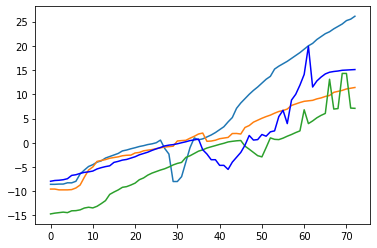

In [1648]:
# fc = fully calibrated
x4, y4, z4, t4 = load_data('data_xyzm_vq1.json')
x5, y5, z5, t5 = load_data('data_xyzm_vq2.json')
x6, y6, z6, t6 = load_data('data_xyzm_vq3.json')
x7, y7, z7, t7 = load_data('data_xyzm_vq4.json')

fc_x4, fc_y4, fc_z4 = apply_calibration(y_factor, x4, y4, z4)
fc_x5, fc_y5, fc_z5 = apply_calibration(y_factor, x5, y5, z5)
fc_x6, fc_y6, fc_z6 = apply_calibration(y_factor, x6, y6, z6)
fc_x7, fc_y7, fc_z7 = apply_calibration(y_factor, x7, y7, z7)

factor = 1.0
plt.plot(fc_y4*factor)
plt.plot(fc_y5*factor)
plt.plot(np.flip(fc_y6)*factor)
plt.plot(np.flip(fc_y7)*factor, color='blue')

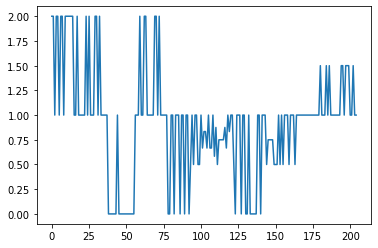

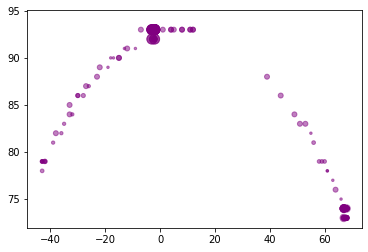

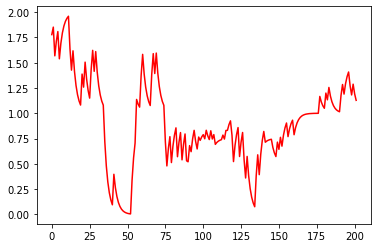

In [1641]:
debug_x, debug_y, debug_z, debug_t = load_data('data_xyzm_debug_hz.json')

debug_cx, debug_cy, debug_cz = apply_calibration(y_factor, debug_x, debug_y, debug_z)

plt.plot(debug_cy)
plt.show()

plt.scatter(x=debug_cx, y=debug_cz, s=abs(debug_cy * 5) ** 2, alpha=0.5, color='purple')
plt.show()

# Try smoothing
debug_cy_adj = []
rolling = 0.0
qty = 3

for idx in range(0, len(debug_cy)):
    py = debug_cy[idx]    
    if idx < qty:
        rolling += py
    else:
        rolling = (rolling - (rolling / qty)) + py
        debug_cy_adj.append(rolling / qty)
    
plt.plot(debug_cy_adj, color='red')
plt.show()



# Calibration outputs

In [1629]:
calibration_factors = np.ndarray((360))
calibration_str = ''

for i in range(0, 360):
    v = closest_factor(y_factor, i)
    calibration_factors[i] = v
    calibration_str += str(round(calibration_factors[i]* 10000)) + ', '
    
calibration_str

'1250, 1250, 1250, 1339, 1429, 1429, 1429, 1667, 1429, 1429, 1667, 1667, 1667, 2000, 1667, 2000, 2000, 2000, 2000, 2000, 1833, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 3333, 2500, 3333, 3333, 3333, 3333, 3333, 3333, 3333, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 7500, 7500, 7500, 7500, 5000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 5000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 5000, 10000, 5000, 5000, 10000, 5000, 10000, 5000, 5000, 5000, 5000, 5000, 5000, 3333, 5000, 4167, 4167, 3333, 5000, 3333, 3333, 3333, 3333, 2917, 2917, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2000, 2000, 2000, 2500, 2000, 2000, 1833, 2000, 1667, 2000, 1667, 1667, 1667, 1667, 1667, 1667, 1429, 1429, 1339, 1339, 1250, 1429, 1429, 1429, 1250, 1250, 1250, 1250, 1111, 1111, 1111, 1111, 1111, 1